<a href="https://colab.research.google.com/github/mdominguezd/DomainAdaptationCashewCropMapping_MGIThesis/blob/main/04_Cashew%20crop%20models/04_02_TrainUNet_With_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using U-Net model to predict cashew crop extent remote sensing images

## 1) Import data and create dataset

In [1]:
!wget -O Tanzania.zip https://www.dropbox.com/scl/fi/hrvixl2a6amc7y8trza2d/PlanetTanzania.zip?rlkey=khxf3vp2cmm3rue7fqwi9rmxp&dl=0
!wget -O IvoryCoast.zip https://www.dropbox.com/scl/fi/lymeixhclxng0gowe9sp7/PlanetIvoryCoast.zip?rlkey=4zuq1y9bed85ruk3lmzkpqwgn&dl=0

--2023-11-01 18:18:46--  https://www.dropbox.com/scl/fi/hrvixl2a6amc7y8trza2d/PlanetTanzania.zip?rlkey=khxf3vp2cmm3rue7fqwi9rmxp
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c0cf5bb856e12782d387f2657.dl.dropboxusercontent.com/cd/0/inline/CGvup-ddxj3KClB1dstvzPYFjzi8ysIgjATaxJ1NIjekNpfigc-sxgYjA1cfNSiyDy7TGOtHG3sn6fcBgMAxsNBQSjPVIHp_Lfs3D8hQ6MRPGkxJ5e0oF7YvEdidiq8sjwu2HrkB5XLOg5iIZBzFPRCa/file# [following]
--2023-11-01 18:18:47--  https://uc7c0cf5bb856e12782d387f2657.dl.dropboxusercontent.com/cd/0/inline/CGvup-ddxj3KClB1dstvzPYFjzi8ysIgjATaxJ1NIjekNpfigc-sxgYjA1cfNSiyDy7TGOtHG3sn6fcBgMAxsNBQSjPVIHp_Lfs3D8hQ6MRPGkxJ5e0oF7YvEdidiq8sjwu2HrkB5XLOg5iIZBzFPRCa/file
Resolving uc7c0cf5bb856e12782d387f2657.dl.dropboxusercontent.com (uc7c0cf5bb856e12782d387f2657.dl.dropboxusercontent.com)... 162.125.3.15, 

Import necessary libraries

In [2]:
!pip install torchmetrics -q
!pip install d2l==0.14.2 -q

import os
import numpy as np
import geopandas as gpd
import pandas as pd
from zipfile import ZipFile
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as T
from torch.utils.data import random_split
from skimage import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import shutil
from torch.autograd import Function
from torchmetrics import F1Score
from torchmetrics.classification import BinaryF1Score
from d2l import torch as d2l
from collections import deque
from statistics import mean
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.2 MB/s eta 0:00:00


### Unzip and remove zipped files

In [3]:
with ZipFile("Tanzania.zip", 'r') as zipped:
    zipped.extractall(path="./")
with ZipFile("IvoryCoast.zip", 'r') as zipped:
    zipped.extractall(path="./")

os.remove('Tanzania.zip')
os.remove('IvoryCoast.zip')

## 2) Create DataSet Classes

### 2.1) Set Image Augmentation transforms.

In [4]:
np.random.seed(1)

def brightness(i, increase = 0.4, prob = 0.5):
    if i.unique().shape[0] > 2: # Hard code to avoid doing the transform to GT data.
        p = np.random.random(1)
        if p < prob:
            p_inc = np.random.random(1)
            i = i*(1 + increase*p_inc)
            i[i>1] = 1.0
        else:
            p_dec = np.random.random(1)
            i = i*((1 - increase*p_dec))

    return i.float()


transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # T.RandomResizedCrop((256,256), scale = (0.8,1)),
    # T.Lambda(brightness)
    ])

### 2.2.) Create Source and Target Class

In [5]:
class Img_Dataset(Dataset):
  def __init__(self, img_folder, transform = None, split = 'Train'):
    self.img_folder = img_folder
    self.transform = transform
    self.split = split

  def __len__(self):
    return sum([self.split in i for i in os.listdir(self.img_folder)])//2

  def plot_imgs(self, idx):
    fig, ax = plt.subplots(1,2,figsize = (12,6))

    im, g = self.__getitem__(idx)

    ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
    ax[0].set_title('Planet image')
    ax[1].imshow(g[0,:,:])
    ax[1].set_title('Cashew crops GT')

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx.

    conversion = T.ToTensor()
    img = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)

    # img = img/np.max(img, 0)

    img = img/1500

    img[img > 1] = 1

    img = conversion(img).float()

    img = torchvision.tv_tensors.Image(img)

    GT = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'GT_{:05d}'.format(idx) + '.tif').astype(np.float32)

    GT = torch.flip(conversion(GT), dims = (1,))

    GT = torchvision.tv_tensors.Image(GT)

    if self.transform != None:
        GT, img = self.transform(GT, img)

    return img, GT

In [6]:
DS = Img_Dataset('IvoryCoast', transform)
# DS = Img_Dataset('Tanzania', transform)

DS.__len__()

7778

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


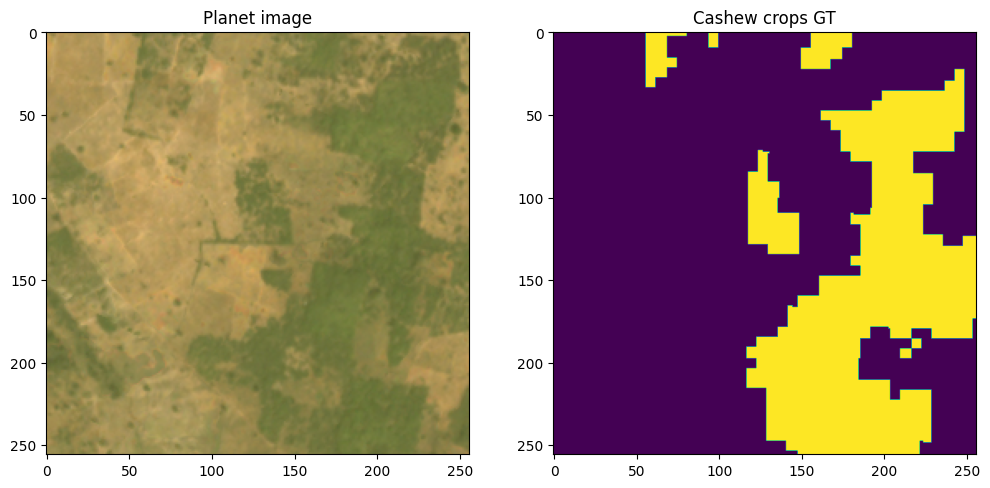

In [7]:
DS.plot_imgs(1530)

### 3) Build the model

### 3.1) Building blocks of a UNet

Take from: https://github.com/milesial/Pytorch-UNet/tree/master

In [8]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # print('not upsampled', x1.shape)
        x1 = self.up(x1)
        # print('upsampled', x1.shape)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # print(diffY, diffX)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        # print('concatenated', x.shape)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### 3.2) Add Gradient Reversal Layer

Adapted from: https://github.com/tadeephuy/GradientReversal/tree/master


In [9]:
class GradientReversal(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.save_for_backward(x, alpha)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        _, alpha = ctx.saved_tensors
        if ctx.needs_input_grad[0]:
            grad_input = - alpha*grad_output
        return grad_input, None

revgrad = GradientReversal.apply

class GradientReversal(nn.Module):
    def __init__(self, alpha = 1):
        super().__init__()
        self.alpha = torch.tensor(alpha, requires_grad=False)

    def forward(self, x):
        return revgrad(x, self.alpha)

class OutDisc(nn.Module):
    def __init__(self, in_feat, mid_layers):
        super(OutDisc, self).__init__()
        self.D = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_feat, out_features=mid_layers, bias = False),
            nn.ReLU(),
            nn.Linear(in_features = mid_layers, out_features = mid_layers//2, bias = False),
            nn.ReLU(),
            nn.Linear(in_features = mid_layers//2, out_features = 1, bias = False)
        )

    def forward(self, x):
        return self.D(x)

### 3.3) Building blocks of Feature Extractor (FE), Classifier (C) and Discriminator (D)

In [10]:
class FE(nn.Module):
    """
      Class for the creation of the feature extractor.
    """
    def __init__(self, n_channels, starter, up_layer, bilinear = True):
        super(FE, self).__init__()

        self.n_channels = n_channels
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer

        # Layers related to segmentation task
        self.inc = (DoubleConv(self.n_channels, self.starter))
        self.down1 = (Down(self.starter, self.starter*(2**1)))
        self.down2 = (Down(self.starter*(2**1), self.starter*(2**2)))
        self.down3 = (Down(self.starter*(2**2), self.starter*(2**3)))
        factor = 2 if bilinear else 1
        self.down4 = (Down(self.starter*(2**3), self.starter*(2**4) // factor))
        if self.up_layer >= 1:
            self.up1 = (Up(self.starter*(2**4), self.starter*(2**3) // factor, bilinear))
        if self.up_layer >= 2:
            self.up2 = (Up(self.starter*(2**3), self.starter*(2**2) // factor, bilinear))
        if self.up_layer >= 3:
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
        if self.up_layer >= 4:
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))

    def DownSteps(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        return x1, x2, x3, x4, x5

    def forward(self, x):

        # Downsample steps
        x1, x2, x3, x4, x5 = self.DownSteps(x)

        # Upsample steps
        if self.up_layer == 0:
            x = x5
        if self.up_layer >= 1:
            x = self.up1(x5, x4)
        if self.up_layer >= 2:
            x = self.up2(x, x3)
        if self.up_layer >= 3:
            x = self.up3(x, x2)
        if self.up_layer >= 4:
            x = self.up4(x, x1)

        return x

class C(nn.Module):
    def __init__(self, n_channels, starter, up_layer, bilinear = True, n_classes = 2):
        super(C, self).__init__()

        self.n_channels = n_channels
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer
        self.n_classes = n_classes

        factor = 2 if bilinear else 1

        if self.up_layer == 0:
            self.up1 = (Up(self.starter*(2**4), self.starter*(2**3) // factor, bilinear))
            self.up2 = (Up(self.starter*(2**3), self.starter*(2**2) // factor, bilinear))
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 1:
            self.up2 = (Up(self.starter*(2**3), self.starter*(2**2) // factor, bilinear))
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 2:
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 3:
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 4:
            self.outc = (OutConv(self.starter, n_classes))


    def forward(self, x, dw):
        # Downsample steps
        x1, x2, x3, x4, x5 = dw

        # Upsampling steps
        if self.up_layer == 0:
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 1:
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 2:
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 3:
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 4:
            logits = self.outc(x)

        return logits

class D(nn.Module):
    def __init__(self, initial_features, bilinear=True, starter = 8, up_layer = 3):
        super(D, self).__init__()

        self.initial_features = initial_features
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer

        factor = 2 if bilinear else 1

        self.revgrad = (GradientReversal())
        self.outd = (OutDisc(self.initial_features, 20))

        if self.up_layer > 0:
            self.down4_D = (Down(self.starter*(2**3)//factor, self.starter*(2**4) // factor))
        if self.up_layer > 1:
            self.down3_D = (Down(self.starter*(2**2)//factor, self.starter*(2**3)//factor))
        if self.up_layer > 2:
            self.down2_D = (Down(self.starter*(2**1)//factor, self.starter*(2**2)//factor))
        if self.up_layer > 3:
            self.down1_D = (Down(self.starter, self.starter*2//factor))

    def forward(self, x):

        x = self.revgrad(x)

        if self.up_layer == 1:
            x = self.down4_D(x)
        if self.up_layer == 2:
            x = self.down3_D(x)
            x = self.down4_D(x)
        if self.up_layer == 3:
            x = self.down2_D(x)
            x = self.down3_D(x)
            x = self.down4_D(x)
        if self.up_layer == 4:
            x = self.down1_D(x)
            x = self.down2_D(x)
            x = self.down3_D(x)
            x = self.down4_D(x)

        x = self.outd(x)

        return x

### 5.4) Build U-Net model

Adapted from: https://github.com/milesial/Pytorch-UNet/tree/master

In [11]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, starter = 8, up_layer = 3):

        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer

        self.FE = (FE(self.n_channels, self.starter, self.up_layer, self.bilinear))
        self.C = (C(self.n_channels, self.starter, self.up_layer, self.bilinear, self.n_classes))
        # self.D = (D(biliniear = self.bilinear, starter = self.starter, up_layer = self.up_layer))

        self.apply(self._init_weights)

    def forward(self, x):

        features = self.FE(x) # Feature extractor
        down_st = self.FE.DownSteps(x) # Get channels that will be concatenated from downward steps

        logits = self.C(features, down_st) # Classifier

        return logits


    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

class disc(nn.Module):
    def __init__(self, in_feat, bilinear=True, starter = 8, up_layer = 3):

        super(disc, self).__init__()

        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer
        self.in_feat = in_feat

        self.D = (D(initial_features=self.in_feat, bilinear = self.bilinear, starter = self.starter, up_layer = self.up_layer))

    def forward(self, x):

        disc = self.D(x)

        return disc

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)

## 4) Set Hyperparameters

In [12]:
#Set params
batch_size = 16
epochs = 20
learning_rate = 0.4
momentum = 0
n_ch = 4
n_cl = 2
bi = True
st = 8
up_l = 4

seg_loss = torch.nn.CrossEntropyLoss()
domain_loss = torch.nn.BCEWithLogitsLoss()

## 5) Split datasets


In [13]:
CIV_train_DS = Img_Dataset('IvoryCoast', transform)
CIV_val_DS = Img_Dataset('IvoryCoast', split = 'Validation')
CIV_test_DS = Img_Dataset('IvoryCoast', split = 'Test')

TNZ_train_DS = Img_Dataset('Tanzania', transform)
TNZ_val_DS = Img_Dataset('Tanzania', split = 'Validation')
TNZ_test_DS = Img_Dataset('IvoryCoast', split = 'Test')

CIV_n_batches = np.ceil(len(CIV_train_DS)/(batch_size/2))
TNZ_n_batches = np.ceil(len(TNZ_train_DS)/(batch_size/2))

n_batches = min(CIV_n_batches, TNZ_n_batches)

batch_iterations = np.ceil(max(CIV_n_batches, TNZ_n_batches) / n_batches)

# Create data loaders
CIV_train_loader = torch.utils.data.DataLoader(dataset=CIV_train_DS, batch_size=batch_size//2, shuffle=True)

# Create data loaders
TNZ_train_loader = torch.utils.data.DataLoader(dataset=TNZ_train_DS, batch_size=batch_size//2, shuffle=True)


# Validation and test dataloaders
CIV_val_loader = torch.utils.data.DataLoader(dataset=CIV_val_DS, batch_size=batch_size//2, shuffle=False)
CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_test_DS, batch_size=batch_size//2, shuffle=False)
TNZ_val_loader = torch.utils.data.DataLoader(dataset=TNZ_val_DS, batch_size=batch_size//2, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_test_DS, batch_size=batch_size//2, shuffle=False)

## 6) Train model

### 6.1) Device settings

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### 6.2) Training loop

In [15]:
target_loader = TNZ_train_loader
source_loader = CIV_train_loader

network = UNet(n_channels=n_ch, n_classes=n_cl, bilinear=bi, starter = st, up_layer = up_l).to(device)

in_feat = 16**2 * st*(2**3) # Number of features that go in the fully connected layers depends on the number of starting channels
discriminator = disc(in_feat, bi, st, up_l).to(device)

D_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
C_params = sum(p.numel() for p in network.parameters() if p.requires_grad)

print('U-Net parameters: ' + str(C_params) +
      '\nDiscriminator parameters: ' + str(D_params) +
      '\nTotal parameters: ' + str(C_params + D_params))

U-Net parameters: 270978
Discriminator parameters: 402098
Total parameters: 673076


In [16]:
optim = torch.optim.SGD(list(discriminator.parameters()) + list(network.parameters()), lr=learning_rate, momentum = momentum)

In [17]:
segmen_loss_l = []
train_accuracy_l = []
domain_loss_l = []

for epoch in range(epochs):

    T_DS = TNZ_train_DS

    for k in range(int(batch_iterations)):
        if (k == int(batch_iterations)-1):
            temp_S_DS = torch.utils.data.Subset(CIV_train_DS, [i for i in np.arange(int(k*len(TNZ_train_DS)), len(CIV_train_DS), 1)])
        else:
            temp_S_DS = torch.utils.data.Subset(CIV_train_DS, [i for i in np.arange(int(k*len(TNZ_train_DS)), int((k+1)*len(TNZ_train_DS)), 1)])

        # Create train data loaders
        S_loader = torch.utils.data.DataLoader(dataset=temp_S_DS, batch_size=batch_size//2, shuffle=True)
        T_loader = torch.utils.data.DataLoader(dataset=T_DS, batch_size=batch_size//2, shuffle=True)

        batches = zip(S_loader, T_loader)

        n_batches = min(len(S_loader), len(T_loader))

        # print(n_batches)

        network.train()
        discriminator.train()

        total_domain_loss = total_segmentation_accuracy = segment_loss = 0

        iterable_batches = enumerate(batches)

        for k in range(n_batches):

            i, (source, target) = next(iterable_batches)

            source_input = source[0].to(device)
            target_input = target[0].to(device)

            input = torch.cat([source_input, target_input])

            source_GT = source[1].type(torch.long).squeeze().to(device)
            target_GT = target[1].type(torch.long).squeeze().to(device)

            # Calculate segmentation and domain groung truth labels
            seg_GT = source_GT
            domain_labels = torch.cat([torch.zeros(source_input.shape[0]),
                                        torch.ones(target_input.shape[0])]).to(device)

            # Get predictions
            features = network.FE(input)
            dw = network.FE.DownSteps(input)
            seg_preds = network.C(features, dw)
            dom_preds = discriminator(features)

            # Calculate the loss function
            segmentation_loss = seg_loss(seg_preds[:source_input.shape[0]], seg_GT)
            discriminator_loss = domain_loss(dom_preds.squeeze(), domain_labels)

            loss = 0.9 * discriminator_loss + 1.1 * segmentation_loss

            # Perform the backward propagation
            optim.zero_grad()
            loss.backward()
            optim.step()

            f1 = BinaryF1Score().to(device)

            # Add loss and accuracy to total
            total_domain_loss += discriminator_loss.item()
            segment_loss += segmentation_loss.item()
            total_segmentation_accuracy += f1(seg_preds[:source_input.shape[0]].max(1)[1], seg_GT).item()

    total_domain_loss /= n_batches
    domain_loss_l.append(total_domain_loss)

    segment_loss /= n_batches
    segmen_loss_l.append(segment_loss)

    total_segmentation_accuracy /= n_batches
    train_accuracy_l.append(total_segmentation_accuracy)

    print(total_domain_loss, total_segmentation_accuracy)

0.6930648245478189 0.4129917973789239
0.6931471824645996 0.473565427846806
0.6931471824645996 0.48340625772553103
0.6931471824645996 0.4912084785680617
0.6931471824645996 0.5011399082278692
0.6931471824645996 0.5078639346425251
0.6931471824645996 0.5153229867899289
0.6931471824645996 0.5288476263002683
0.6931471824645996 0.5268360502937789
0.6931471824645996 0.5344871293793443
0.6931471824645996 0.5401850876308256
0.6931471824645996 0.5439529194626757
0.6931471824645996 0.543335775854767
0.6931471824645996 0.5504233548718114
0.6931471824645996 0.5490489504350129
0.6931471824645996 0.5553692063336731
0.6931471824645996 0.5532558565178225
0.6931471824645996 0.5585716225767648
0.6931471824645996 0.5629664403136059
0.6931471824645996 0.5622822377950915


In [18]:
torch.save(network, 'U_Net_DANN_4L_20epochs.pt')

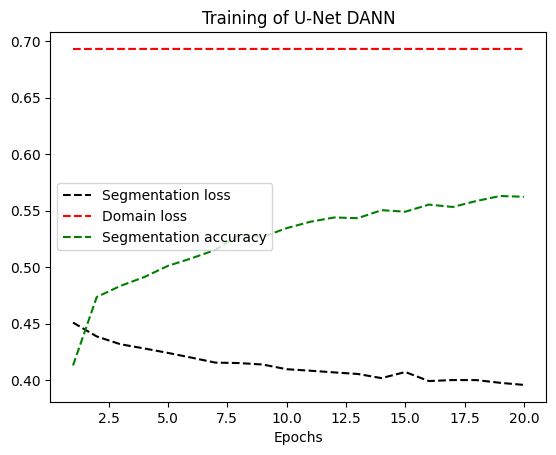

In [19]:
plt.plot(np.arange(1, epochs + 1, 1), segmen_loss_l, '--k', label = 'Segmentation loss')
plt.plot(np.arange(1, epochs + 1, 1), domain_loss_l, '--r', label = 'Domain loss')
plt.plot(np.arange(1, epochs + 1, 1), train_accuracy_l, '--g', label = 'Segmentation accuracy')

plt.legend()

plt.xlabel('Epochs')
plt.title('Training of U-Net DANN')

fig = plt.gcf()

fig.savefig('U-Net_DANN_4L_TrainingLoop.png')

In [21]:
iterable_test = enumerate(CIV_test_loader)

accurate = 0
mistake = 0

for i, (img, gt) in iterable_test:
    print(discriminator(img[0]) == 0)

# iterable_test = enumerate(TNZ_test_loader)

# for i, (img, gt) in iterable_test:
#     if discriminator(img) == 0:
#         accurate += 1
#     else:
#         mistake += 1

print(accurate, mistake, accurate/(accurate + mistake))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


RuntimeError: ignored

In [23]:
img.shape

torch.Size([8, 4, 256, 256])

In [ ]:
target_loader = TNZ_train_loader
source_loader = CIV_train_loader

batches = zip(source_loader, target_loader)
n_batches = min(len(source_loader), len(target_loader))

def validate_seg(network, validation_loader, seg_loss, domain_loss):

    network.eval()
    metric = pd.DataFrame([])

    with torch.no_grad():
        for i, (inputs, GTs) in enumerate(validation_loader):

            inputs = inputs.to(device)
            GTs = GTs.type(torch.long).squeeze().to(device)
            pred_seg, pred_dom  = network(inputs)
            s_loss = seg_loss(pred_seg, GTs)
            overall_accuracy = (pred_seg.max(1)[1]==GTs).float().mean()

            # d_loss = domain_loss(pred_dom, 1)

            metric = pd.concat([metric, pd.DataFrame([[s_loss.cpu().numpy(), overall_accuracy.cpu().numpy()]])])

    metric.columns = ['Loss', 'OA']

    return metric.mean()

val_eval = validate_seg(network, val_loader, seg_loss, domain_loss)

val_eval

Loss    0.692955
OA      0.550922
dtype: float64

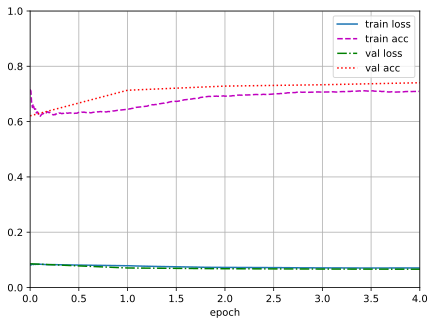

In [ ]:
!pip install d2l==0.14.2 -q
from d2l import torch as d2l
from collections import deque
from statistics import mean


def evaluate(net, validate_loader, loss_function):
  #You need to set the network to eval mode when using batch normalization (to
  #be consistent across evaluation samples, we use mean and stddev computed
  #during training when doing inference, as opposed to ones computed on the
  #batch) or dropout (you want to use all the parameters during inference).
  net.eval()  # Set the model to evaluation mode
  device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(4)
  #This line reduces the memory by not tracking the gradients. Also to be used
  #during inference.
  with torch.no_grad():
    for i, (inputs, GTs) in enumerate(validate_loader):
      #Send inputs and GTs them to the computation device (i.e. GPU). The GTs tensor
      #has to be converted to nn.LongTensor type (a type of integer) and turned into
      #a 3D tensor by removing dimension 1 with the squeeze() function.
      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      pred = network(inputs)
      # pred = pred[:,0,:,:].float()
      # print(pred[0,0,0], GTs[0,0,0])
      loss = loss_function(pred, GTs)
      overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
      metric.add(loss, GTs.shape[0], overall_accuracy, 1)
  return metric


number_epochs = epochs

animator = d2l.Animator(xlabel='epoch', xlim=[0, number_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'val loss', 'val acc'],
                        fmts=('-', 'm--', 'g-.', 'r:'),
                        figsize=(7, 5))

network = UNet(n_channels=4, n_classes=2, bilinear=True, starter = 4, up_layer = 2)
network.to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
# optim = torch.optim.Adam(list(discriminator.parameters()) + list(model.parameters()))
#Training metrics are computed as a running average of the last x samples
loss_train = deque(maxlen=len(train_loader))
accuracy_train = deque(maxlen=len(train_loader))

for epoch in range(number_epochs):
  #Validation phase:
  metric_val = evaluate(network, val_loader, loss_function)
  animator.add(epoch,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

  #Training phase:
  network.train() #indicate to the network that we enter training mode
  for i, (inputs, GTs) in enumerate(train_loader):
    inputs = inputs.to(device)
    GTs = GTs.type(torch.long).squeeze().to(device)
    #We set the gradients of the model to 0.
    optimizer.zero_grad()
    pred = network(inputs)
    loss = loss_function(pred, GTs)
    overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
    #We accumulate the gradients...
    loss.backward()
    #...and we update the parameters according to the gradients.
    optimizer.step()
    loss_train.append(loss.item()/GTs.shape[0])
    accuracy_train.append(overall_accuracy.item())
    animator.add(epoch+i/len(train_loader),
                      (mean(loss_train), mean(accuracy_train), None, None))


  if (epoch//2 == epoch/2):
      #After each training epoch, reduce the learning rate by a factor of 0.2
      optimizer.param_groups[0]['lr'] *= 0.2

metric_val = evaluate(network, val_loader, loss_function)
animator.add(epoch+1,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

In [ ]:
torch.save(network, 'U_Net_TargetOnlyTNZwithImAug.pt')

## 7) Assess model predictions

In [ ]:
def F1(pred, gt):

    cl = pred - gt.numpy()
    FN = np.sum(cl == -1)
    FP = np.sum(cl == 1)
    TN = np.sum(pred[((pred == 0)&(cl == 0))[0]])
    TP = np.sum(pred[((pred == 1)&(cl == 0))[0]])

    if TP == 0 :
      F1 = 0
    else:
      prec = TP/(TP+FP)
      recall = TP/(TP+FN)

      F1 = 2*(prec*recall)/(prec+recall)

    return F1

t_DS = Tanzania_Dataset('Tanzania')
c_DS = Ivy_Dataset('IvoryCoast')

l = []
oa = []

for i in range(test_DS.__len__()):
  img, gt = test_DS.__getitem__(i)

  pred = network(img[None, :, :, :].to(device))
  pred = pred[0,:,:,:].max(0)[1].cpu().numpy()

  overall_accuracy = np.mean(pred == gt.numpy())
  f1 = F1(pred, gt)

  l.append(f1)
  oa.append(overall_accuracy)

  if f1 > 0.95:
      img = img[[2,1,0], :, :].permute(1,2,0)

      f, ax = plt.subplots(1,2,figsize = (16,8))
      ax[0].imshow(img)
      ax[0].imshow(gt[0], alpha = 0.4, cmap = 'gray', vmin = 0, vmax = 1)
      ax[0].set_title('Reference data')

      ax[1].imshow(img)
      ax[1].imshow(pred, alpha = 0.4, cmap = 'gray', vmin = 0, vmax = 1)
      ax[1].set_title('Prediction')

      plt.suptitle('Overall Accuracy: ' + str(overall_accuracy) + '\nF1-Score: '+str(f1))

In [ ]:
mean(l)

0.3486899621012369

In [ ]:
mean(oa)

0.5375735852145409

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, network.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

270978


In [ ]:
batch = next(iterable_train_loader)

pred = network(batch[1][0].to(device))

# print(loss_function(pred, batch[1][1].to(device)))
print('This is batch number '+ str(batch[0]))
fig, axs = plt.subplots(batch_size, 3)
fig.set_size_inches(15,5*batch_size)
for i in range(batch_size):
  axs[i,0].imshow(batch[1][0].permute(0,2,3,1)[i,:,:,[2,1,0]], vmin =0, vmax = 1)
  axs[i,1].imshow(batch[1][1][i,0,:,:],cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
  axs[i,2].imshow(pred[i,:,:,:].max(0)[1].cpu(),cmap=plt.get_cmap('gray'))
axs[0,0].set_title('Image')
axs[0,1].set_title('GT')
axs[0,2].set_title('Prediction')

This is batch number 29


Text(0.5, 1.0, 'Prediction')

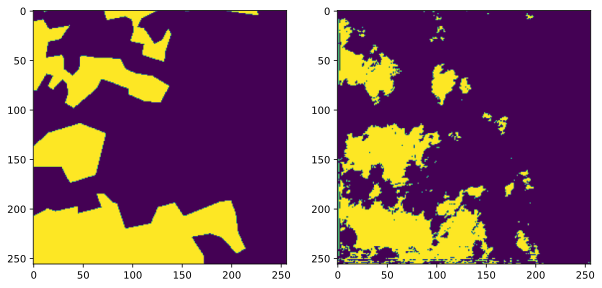

In [ ]:
im, gt = DS.__getitem__(700)
pred = network(im[None, :, :, :].to(device))
pred_ = pred[0,:,:,:].max(0)[1].cpu().numpy()

figs, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(gt[0])
ax[1].imshow(pred_)